# Dog Breed Detector

In this notebook, we are going to train a model for detecting different breeds of dog from the image.

# Installing Dependencies

During this notebook, the following dependencies are required.

In [1]:
%pip install -Uqqq fastai duckduckgo_search ipywidgets

Note: you may need to restart the kernel to use updated packages.


## Data Gathering

The first task of every AI model training is data gathering. I'm going to use duckduckgo search engine to gather images of a couple of dog breeds. I guess 200 images per breed would be fine.

In [7]:
from duckduckgo_search import DDGS
from typing import List
from operator import itemgetter


search_engine = DDGS(timeout=20)


def search_images(keywords: str, max_results: int = 10) -> List[str]:
    results = search_engine.images(keywords, max_results=max_results)
    return list(map(itemgetter("image"), results))

In [6]:
from enum import Enum


class DogBreed(Enum):
    GOLDEN_RETRIEVER = "golden_retriever"
    BULLDOG = "bulldog"
    GERMAN_SHEPHERD = "german_shepherd"

In [ ]:
from pathlib import Path

dog_images_path = Path.cwd() / "dog_images"
dog_images_path.mkdir(exist_ok=False)

In [2]:
from fastai.vision.all import *

In [6]:
from math import ceil


def chunk_list(input_list, chunk_size: int = 10):
    num_of_chunks = ceil(len(input_list) / chunk_size)

    return [
        input_list[i * chunk_size : (i * chunk_size) + chunk_size]
        for i in range(0, num_of_chunks)
    ]

In [7]:
from time import sleep

for breed in DogBreed:
    search_keyword = breed.value.replace("_", " ")
    image_links = search_images(search_keyword, max_results=200)

    chunk_number = 0
    for image_links_chunk in chunk_list(image_links, 50):
        download_images(dog_images_path / breed.value, urls=image_links_chunk)
        print(f"Downloaded breed: {breed.value}, chunk number: {chunk_number}.")
        chunk_number += 1
        sleep(1)

Downloaded breed: golden_retriever, chunk number: 0.
Downloaded breed: golden_retriever, chunk number: 1.
Downloaded breed: golden_retriever, chunk number: 2.
Downloaded breed: golden_retriever, chunk number: 3.
Downloaded breed: bulldog, chunk number: 0.
Downloaded breed: bulldog, chunk number: 1.
Downloaded breed: bulldog, chunk number: 2.
Downloaded breed: bulldog, chunk number: 3.
Downloaded breed: german_shepherd, chunk number: 0.
Downloaded breed: german_shepherd, chunk number: 1.
Downloaded breed: german_shepherd, chunk number: 2.
Downloaded breed: german_shepherd, chunk number: 3.


In [8]:
for breed in DogBreed:
    resize_images(
        dog_images_path / breed.value, max_size=400, dest=dog_images_path / breed.value
    )

In [9]:
for breed in DogBreed:
    breed_images = get_image_files(dog_images_path / breed.value)
    problematic_images = verify_images(breed_images)
    problematic_images.map(Path.unlink)
    print(f"{len(problematic_images)} images of {breed.value} were problematic.")

2 images of golden_retriever were problematic.
4 images of bulldog were problematic.
3 images of german_shepherd were problematic.


## Model Training

When we gathered data, now it's the time to train our model. Note that it might seem intuitive to first do the _data cleaning_ and then train the model but in practice, it should be done the other way around since the model would itself help with the data cleaning phase. Data cleaning is one of the most challenging tasks of a data scientist and takes almost most of their time so it would help a lot to have our model giving a hand in this process.

I'm going to use FastAI's Data Block API to create my dataloaders and then train the model. This is a hugely useful abstraction that let us train our model faster without dealing with the underlying details of data appropriation.

In [3]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
)

### Data Augmentation

Data gathering for an AI problem is not easy! In fact, not having enough data to perform an AI task might throw the whole project out the window.

On the other hand, it is equally hard to train a good model with limited data. One of the techniques that data scientists use to be able to train good models on limited data is _data augmentation_.

Data augmentation is the process of producing different varieties of the same data in a way that it appears different but **does not change the meaning of the data**. Ways to do this include rotating, flipping, perspective warping, brightness changes and contrast changes. It also helps our model to see the same image of an object from different perspectives and therefore get a better feel of the different ways that the mentioned object might be represented.

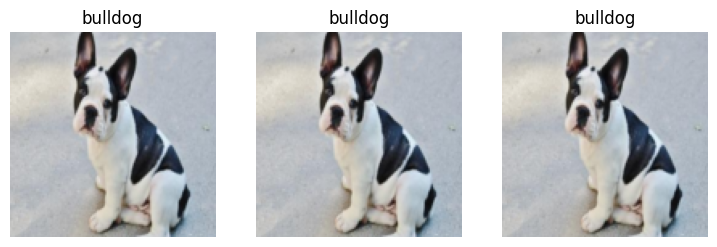

In [11]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(size=128, min_scale=0.3), batch_tfms=aug_transforms()
)

dls = dogs.dataloaders(dog_images_path)

dls.valid.show_batch(max_n=3, nrows=1, unique=True)

### Training

I use the `resnet18` to train my model.

In [9]:
resnet_learn = vision_learner(dls, resnet18, metrics=error_rate)
resnet_learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.485535,0.099821,0.038462,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.405611,0.063276,0.019231,00:10
1,0.325335,0.068826,0.028846,00:11
2,0.289308,0.082537,0.038462,00:12
3,0.237297,0.088947,0.038462,00:14


## Data Cleaning

Now that we have our model, we can use it to clean our data. This process involves multiple iterations where in each one we first clean the data based on the output of the trained model and then do the training again on the cleaned data. We repeat this until we're satisfied by the accuracy of our model.

## Confusion Matrix

In order to know which items in our data should be cleaned, we use a mathematical tool called the _confusion matrix_. The confusion matrix shows whether our model is able to clearly distinguish different categories. We want highest values on the diagonal of this matrix and zeros on off-diagonal entries.

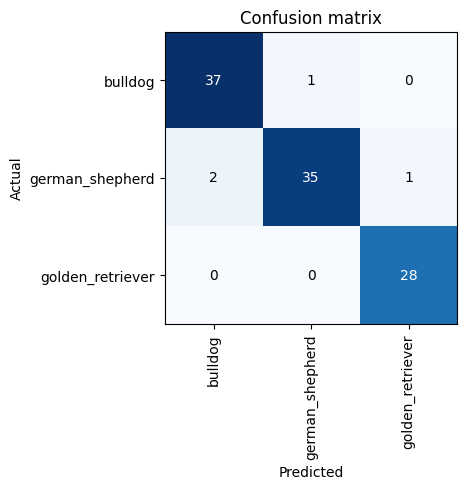

In [12]:
interp = ClassificationInterpretation.from_learner(resnet_learn)
interp.plot_confusion_matrix()

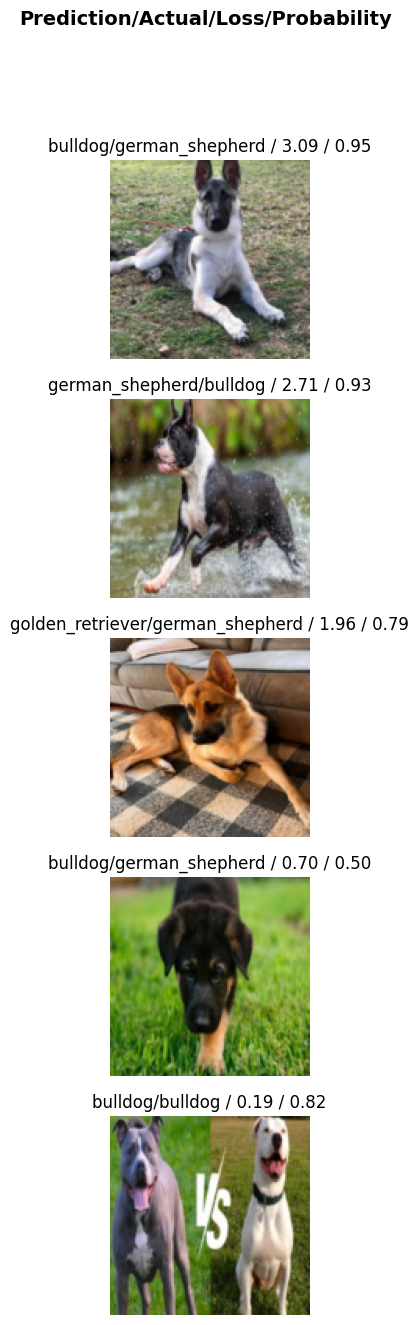

In [13]:
interp.plot_top_losses(5, nrows=5)

In [14]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(resnet_learn)
cleaner

In [57]:
import shutil

for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

for idx, breed in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), dog_images_path / breed)

## Model Export

After a few iterations and when we finally were satisfied by the results of our model, we can export it to use for inference.

In [15]:
resnet_learn.export(fname="dog_breed_detector.pkl")